In [63]:
import torch
import torch as T
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torchsummary import summary
import gym
import numpy as np
import matplotlib.pyplot as plt
import random as rand

### Hyperparameters

In [64]:
alpha = 3e-3
gamma = 0.99
lr1 = 256
lr2 = 256
batch_size = 64
mem_size = 100000
target_update = 10
env_type = "LunarLander-v2"
# env_type = "CartPole-v1"
#Q-value
epsilon = 1.00
radr = 0.997#6e-4
epsilon_min = 0.01

In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [66]:
class NN(nn.Module):
    def __init__(self, alpha, input_, lr1_, lr2_, output_):
        super(NN, self).__init__()
        self.loss = nn.MSELoss()
        self.linear_relu_stack = nn.Sequential(
        nn.Linear(input_, lr1_),
        nn.ReLU(),
        nn.Linear(lr1_, lr2_),
        nn.ReLU(),
        nn.Linear(lr2_, output_))
    
    def forward(self, x):
        return self.linear_relu_stack(x)

In [70]:
class Memory:
    def __init__(self, mem_size):
        self.mem_size = mem_size
        self.mem_state = []
        self.mem_state_prime = []
        self.mem_reward = []
        self.mem_action = []
        self.mem_end_state = []
        self.mem_index = 0
        
    def sample_mem(self, batch_size):
        ind = np.random.choice(len(self.mem_state), batch_size, replace=False)
        #Sample from above index
        state = torch.from_numpy( np.array(self.mem_state)[ind] ).float().to(device)
        state_prime = torch.from_numpy( np.array(self.mem_state_prime)[ind] ).float().to(device)
        reward = torch.from_numpy( np.array(self.mem_reward)[ind] ).float().to(device)
        action = torch.from_numpy( np.array(self.mem_action)[ind] ).long().to(device)
        end_state = torch.from_numpy( np.array(self.mem_end_state)[ind] ).long().to(device)
#         print("Sample Output")
#         print("State",state, "State_prime",state_prime, "Reward",reward, "Action",action, "Done",end_state)
        return state, state_prime, reward, action, end_state
    
    def insert_mem(self, state, state_prime, reward, action, end_state):
        #Check if replay memory filled
        if len(self.mem_state) < self.mem_size:
            self.mem_state.append(state)
            self.mem_state_prime.append(state_prime)
            self.mem_reward.append(reward)
            self.mem_action.append(action)
            self.mem_end_state.append(end_state)
        else:
            self.mem_state[self.mem_index] = state
            self.mem_state_prime[self.mem_index] = state_prime
            self.mem_reward[self.mem_index] = reward
            self.mem_action[self.mem_index] = action
            self.mem_end_state[self.mem_index] = end_state
        #Update index
        self.mem_index = (self.mem_index + 1) % self.mem_size

In [71]:
class Agent():
    def __init__(self, alpha, gamma, epsilon, radr, device, batch_size, mem_size, nS, nA):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.radr = radr
        self.device = device
        self.batch_size = batch_size
        self.mem_size = mem_size
        self.nS = nS
        self.nA = nA
        #DQN things
        self.mem = Memory(mem_size)
        self.policy_nn = NN(alpha=alpha, input_=nS, lr1_=lr1, lr2_=lr2, output_=nA)
        self.target_nn = NN(alpha=alpha, input_=nS, lr1_=lr1, lr2_=lr2, output_=nA)
        self.policy_nn.optimizer = optim.Adam(self.policy_nn.parameters(), lr=alpha)
        self.target_nn.optimizer = optim.Adam(self.target_nn.parameters(), lr=alpha)
    
    def select_action(self, state):
        prob = rand.random()
        if prob < self.epsilon:
            #random action
            a = rand.randint(0, self.nA - 1)
        else:
            #highest valued index is action
            state = T.tensor(state, dtype=torch.float32).to(self.device)
            q_value = self.policy_nn.forward(state)
            a = T.argmax(q_value).item()
        return a
    
    def targetnn_update(self):
        self.target_nn.load_state_dict(self.policy_nn.state_dict())
    
    def learn_fromnn(self):
        if self.mem.mem_index < self.batch_size:
            return
        #Get Data
        state, state_prime, reward, action, end_state = self.mem.sample_mem(self.batch_size)        
        #Get Q-value
        action = action.to(T.int64) #TODO fix
        q_out = self.policy_nn.forward(state).gather(1, action.view(-1, 1))
        q_out_prime = self.target_nn.forward(state_prime).max(dim=1).values
        end_state = end_state.to(T.long)  #TODO fix
        q_out_prime[end_state] = 0.0
        #Update Q-value
        q_target = reward + (self.gamma * q_out_prime)
        q_target = q_target.view(-1, 1)
        #Loss
        self.policy_nn.optimizer.zero_grad()
        loss = F.mse_loss(q_target, q_out).mean()
        loss.backward()
        self.policy_nn.optimizer.step()
    
    def epsilon_decay(self):
        if self.epsilon > epsilon_min:
            self.epsilon = self.epsilon * self.radr

In [72]:
#Train
env = gym.make(env_type)#, render_mode="human")
nS = env.observation_space.shape[0]
nA = env.action_space.n
agent = Agent(alpha, gamma, epsilon, radr, device, batch_size, mem_size, nS, nA)
scores = []
avg_scores = []
eps_history = []
steps = []
n_games = 800
for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    observation = observation[0]
    step = 0
    while not done:
        action = agent.select_action(observation)
        observation_, reward, done, info, _ = env.step(action)
#         env.render()
        score += reward
        agent.mem.insert_mem(observation, observation_, reward, action, done)
        agent.learn_fromnn()
        observation = observation_
        step = step + 1
        if done:
            break
    if (i % target_update) == 0:
        agent.targetnn_update()
    avg_score = np.mean(scores[-100:])
    scores.append(score)
    eps_history. append(agent.epsilon)
    steps.append(step)
    avg_scores.append(avg_score)
    agent.epsilon_decay()
    
    print('episode ', i, 'score ', score, 'average score', avg_score, 'epsilon ', agent.epsilon)

episode  0 score  -314.90895819095965 average score nan epsilon  0.997
episode  1 score  -109.29250876518782 average score -314.90895819095965 epsilon  0.994009
episode  2 score  -124.24833787278571 average score -212.10073347807372 epsilon  0.991026973
episode  3 score  -284.9745047857223 average score -182.81660160964438 epsilon  0.988053892081
episode  4 score  -364.3970863021162 average score -208.35607740366385 epsilon  0.985089730404757
episode  5 score  -175.59663070284364 average score -239.5642791833543 epsilon  0.9821344612135428
episode  6 score  -378.9167354654859 average score -228.90300443660252 epsilon  0.9791880578299021
episode  7 score  15.807169754029886 average score -250.3335374407287 epsilon  0.9762504936564125
episode  8 score  -177.8143679533273 average score -217.0659490413839 epsilon  0.9733217421754432
episode  9 score  -193.62323146349067 average score -212.70466225382205 epsilon  0.9704017769489168
episode  10 score  -180.611222384887 average score -210.796

episode  83 score  -130.3799920746245 average score -145.10397067529607 epsilon  0.776950406379376
episode  84 score  -172.81097378369782 average score -144.92868521576426 epsilon  0.7746195551602378
episode  85 score  -202.32726187383616 average score -145.2567121400929 epsilon  0.7722956964947572
episode  86 score  -139.7640687154444 average score -145.92032318350851 epsilon  0.7699788094052729
episode  87 score  -168.03107934250033 average score -145.8495616378986 epsilon  0.767668872977057
episode  88 score  -190.44959215070818 average score -146.10162433908727 epsilon  0.7653658663581259
episode  89 score  -137.87339056599308 average score -146.59991611225155 epsilon  0.7630697687590515
episode  90 score  -278.97195284294264 average score -146.5029547172931 epsilon  0.7607805594527743
episode  91 score  -109.77135607379107 average score -147.95865799339916 epsilon  0.7584982177744161
episode  92 score  -80.56079396477264 average score -147.54357862470778 epsilon  0.756222723121092

episode  165 score  -100.05778897518384 average score -96.94552156790691 epsilon  0.6072902096189046
episode  166 score  -74.92152368936533 average score -97.0834939530783 epsilon  0.6054683389900478
episode  167 score  -86.60032457807046 average score -96.54259262921474 epsilon  0.6036519339730777
episode  168 score  -32.01589729519101 average score -96.18066912915629 epsilon  0.6018409781711584
episode  169 score  -78.12062613347081 average score -95.78879977912726 epsilon  0.6000354552366449
episode  170 score  -62.09516739485917 average score -94.19974455753612 epsilon  0.598235348870935
episode  171 score  -140.82962747151436 average score -94.22114955876602 epsilon  0.5964406428243222
episode  172 score  -77.53517370359734 average score -94.71152910675801 epsilon  0.5946513208958493
episode  173 score  -99.72034532869029 average score -94.61045484834956 epsilon  0.5928673669331617
episode  174 score  -86.2590444349249 average score -94.80845908503606 epsilon  0.5910887648323622
e

episode  247 score  -179.45279901193103 average score -79.18127334475267 epsilon  0.4746781720825711
episode  248 score  -75.52806660439853 average score -80.19287950092313 epsilon  0.4732541375663234
episode  249 score  -69.2781573709137 average score -80.06052433705594 epsilon  0.4718343751536244
episode  250 score  -125.80978956249494 average score -80.18532944302886 epsilon  0.47041887202816357
episode  251 score  -27.455124919073725 average score -80.04018624820549 epsilon  0.4690076154120791
episode  252 score  -79.63908381688972 average score -79.64927341976606 epsilon  0.46760059256584285
episode  253 score  -122.11626445294564 average score -79.51114573602099 epsilon  0.4661977907881453
episode  254 score  -185.49624612640116 average score -80.00029395101048 epsilon  0.4647991974157809
episode  255 score  -60.79794189697833 average score -81.55069668923507 epsilon  0.46340479982353355
episode  256 score  -287.9983396251606 average score -81.2070453466372 epsilon  0.46201458542

episode  329 score  -70.5351761168119 average score -108.8600850414504 epsilon  0.3710242047093869
episode  330 score  -42.68435633364858 average score -108.93512405266198 epsilon  0.3699111320952587
episode  331 score  -164.31711630189338 average score -108.11919189466964 epsilon  0.36880139869897294
episode  332 score  -153.66636128941997 average score -109.06794350399488 epsilon  0.367694994502876
episode  333 score  -191.11964371527944 average score -109.94832448355815 epsilon  0.3665919095193674
episode  334 score  -153.11553917987706 average score -109.1562580367527 epsilon  0.36549213379080925
episode  335 score  -92.96793598185565 average score -109.78257637585973 epsilon  0.3643956573894368
episode  336 score  -134.256986645883 average score -110.31429885601426 epsilon  0.3633024704172685
episode  337 score  -44.69421444004371 average score -111.08411299330854 epsilon  0.3622125630060167
episode  338 score  -99.63773004384274 average score -110.55275922704948 epsilon  0.361125

episode  410 score  -168.2952061796867 average score -122.72082295774102 epsilon  0.29087745790905184
episode  411 score  -166.14088832626038 average score -123.6109217955516 epsilon  0.2900048255353247
episode  412 score  -160.79032525010413 average score -124.43645180339927 epsilon  0.28913481105871874
episode  413 score  -189.40914604266692 average score -125.29959509896337 epsilon  0.28826740662554257
episode  414 score  -126.4060444327642 average score -126.61495988217025 epsilon  0.28740260440566595
episode  415 score  -183.48558627717728 average score -127.2374586095462 epsilon  0.28654039659244895
episode  416 score  -345.6936088160619 average score -128.2596024976585 epsilon  0.2856807754026716
episode  417 score  -68.63426592839494 average score -130.78410434771985 epsilon  0.2848237330764636
episode  418 score  -144.84354792490944 average score -130.99879782215575 epsilon  0.2839692618772342
episode  419 score  -169.28397827278258 average score -130.5635347366319 epsilon  0.

episode  491 score  -97.25354782958306 average score -132.85652508783915 epsilon  0.22804360051362357
episode  492 score  -123.20070193726501 average score -133.58574700653955 epsilon  0.2273594697120827
episode  493 score  -115.75575642410172 average score -134.26035434158922 epsilon  0.22667739130294645
episode  494 score  -709.1054280026549 average score -134.6062845890163 epsilon  0.22599735912903762
episode  495 score  4.350696277756057 average score -139.6708721366894 epsilon  0.2253193670516505
episode  496 score  -134.11879901203906 average score -138.3422397879325 epsilon  0.22464340895049556
episode  497 score  -140.67736424142447 average score -138.2310597007555 epsilon  0.22396947872364406
episode  498 score  -126.14478162752748 average score -138.0126191390045 epsilon  0.22329757028747313
episode  499 score  -128.77122255209898 average score -138.23059528549808 epsilon  0.2226276775766107
episode  500 score  -107.67286773833143 average score -137.65881337856837 epsilon  0.

episode  572 score  -40.604061845527205 average score -189.99866795114667 epsilon  0.17878279090116736
episode  573 score  -40.37231684440087 average score -189.10635741620084 epsilon  0.17824644252846386
episode  574 score  -99.08230792083911 average score -188.00804683308957 epsilon  0.17771170320087848
episode  575 score  -90.31081087310558 average score -188.02770916608014 epsilon  0.17717856809127586
episode  576 score  -55.75718669017562 average score -187.70298305456848 epsilon  0.17664703238700202
episode  577 score  -93.43375784590079 average score -187.29479192805667 epsilon  0.17611709128984102
episode  578 score  -131.90229525713215 average score -187.01769375793793 epsilon  0.1755887400159715
episode  579 score  -685.4535902531247 average score -187.55269091259345 epsilon  0.1750619737959236
episode  580 score  -68.02046431521546 average score -193.06548771134584 epsilon  0.1745367878745358
episode  581 score  -117.10402939224849 average score -192.64196350968123 epsilon  

episode  653 score  -153.1656845492603 average score -135.76767589503922 epsilon  0.14016304886617945
episode  654 score  -69.6767909340802 average score -136.06670442794285 epsilon  0.1397425597195809
episode  655 score  -131.6857409819182 average score -135.94260628805586 epsilon  0.13932333204042216
episode  656 score  -120.14624340547934 average score -136.09887591320424 epsilon  0.1389053620443009
episode  657 score  -68.4449902702171 average score -136.32694231479218 epsilon  0.138488645958168
episode  658 score  -134.08033413610295 average score -134.74802300216044 epsilon  0.1380731800202935
episode  659 score  -114.15636385339337 average score -131.9414715870657 epsilon  0.13765896048023263
episode  660 score  -108.7509451224124 average score -131.78900293899977 epsilon  0.13724598359879192
episode  661 score  -127.25242943690084 average score -129.67660015727745 epsilon  0.13683424564799554
episode  662 score  -123.7233855644037 average score -130.3975369290303 epsilon  0.136

episode  734 score  -101.3622311534851 average score -91.06142251582494 epsilon  0.10988574553757426
episode  735 score  -23.46957081833672 average score -90.85029560621604 epsilon  0.10955608830096153
episode  736 score  -79.11021994617813 average score -90.19205656753009 epsilon  0.10922742003605865
episode  737 score  -4.325933232774304 average score -89.58213567935107 epsilon  0.10889973777595047
episode  738 score  -49.55166565032568 average score -88.19149564151695 epsilon  0.10857303856262261
episode  739 score  -499.2397451831191 average score -87.78507983593755 epsilon  0.10824731944693475
episode  740 score  -129.6483229714516 average score -91.64247724783837 epsilon  0.10792257748859395
episode  741 score  224.8106294104358 average score -91.99921416857362 epsilon  0.10759880975612816
episode  742 score  -181.23882824435802 average score -88.25734694889994 epsilon  0.10727601332685978
episode  743 score  -140.92694834057082 average score -88.8604558989076 epsilon  0.10695418

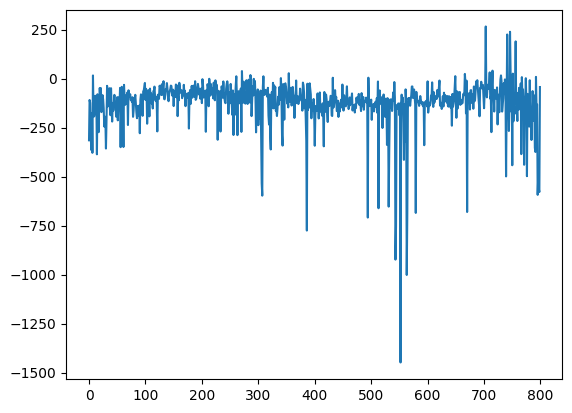

In [73]:
plt.plot(range(n_games), scores)

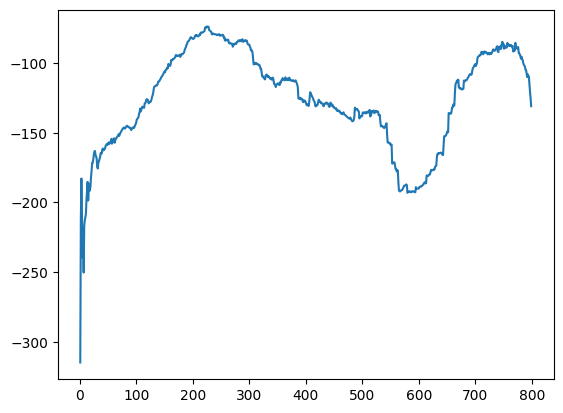

In [74]:
plt.plot(range(n_games), avg_scores)

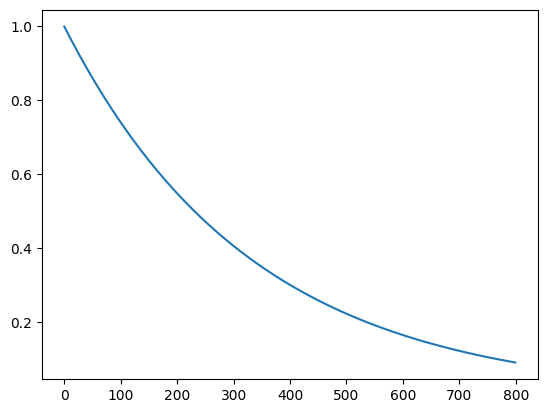

In [75]:
plt.plot(range(n_games), eps_history)

In [ ]:
#Test

In [ ]:
#Plot Graphs